### Setup and index
Select a single measurement from database

In [97]:
import lib.csv_helpers as csv
import lib.data_process 
import lib.json_setup as json_setup
import matplotlib.pyplot as plt
import os
import numpy as np

# change directory to wherever you have your setup and data folders
os.chdir('/Users/calum/spectrometer/')

# select the appropriate setup file, and read it in
setup_path = "setup/20220818_s44076.json"
setup = json_setup.json_to_dict(setup_path)

# Read in the index file of the metadata 
meta_df = csv.read_metadata(setup)

# Filter for the measurement you are interested in
# This example expects just a single measurement (but multiple repeats are OK)
meta_df = csv.select_from_metadata('fluid', 'Air', meta_df)
meta_df = csv.select_from_metadata('element', 'A01', meta_df)
meta_df



INFO:root:filtering by metadata "fluid" == "Air"
INFO:root:filtering by metadata "element" == "A01"


,date,instrument,sensor,element,structure,surface,fluid,repeats,comment
index,,,,,,,,,
s44076_pre-iDOT-A01-Air,2022-08-18,broadbandLED_instrument,s44076_pre-iDOT,A01,-,[,Air,3,<NA>


### Process data

This example 
- averages measurement repeats,
- finds the first derivative,
- trims it at +/-100nm around the literal minimum,
- does a 30 point rolling smooth

The inflection points can then be found

In [119]:

# Read in the actual spectral data, merging all measurements into a single dataframe
merged_df, title = csv.merge_dataframes(setup, meta_df)

# Configure the parameters for processing the data
dp = lib.data_process.DataProcessor()
dp.apply_avg_repeats = True
dp.apply_normalise = False
dp.apply_smooth = False
dp.apply_trim = False
dp.apply_interpolate = False
dp.apply_round = True

dp.smooth_points = 3
dp.wavelength_trim_min = 540
dp.wavelength_trim_max = 730
dp.round_decimals = 3

# Apply the processing
df = dp.process_dataframe(merged_df)


# Define a custom function
def derivative(df, trim_nm=100, smooth_points=30):
    for col in df:
        if col == 'wavelength':
            pass
        else:
            wl_minimum = df['wavelength'].iloc[df[col].idxmin()]

            # Not currently doing absorption...
            # df[f'{col}_absorption'] = 2-np.log10(df[col])

            # Add a new column with suffix _deriv.
            # This does a simple delta y / delta x type of derivative
            df[f'{col}_deriv'] = df[col].diff() / df['wavelength'].diff()

            # trim the derivative at +/- trim_nm around the minimum
            df[f'{col}_deriv'] = df[f'{col}_deriv'].loc[df['wavelength'] >= wl_minimum -trim_nm]
            df[f'{col}_deriv'] = df[f'{col}_deriv'].loc[df['wavelength'] <= wl_minimum +trim_nm]

            # apply smoothing to derivative
            df[f'{col}_deriv_smoothed'] = df[f'{col}_deriv'].rolling(window=smooth_points, center=True).mean()

    return df

# Apply custom function
df = derivative(df, trim_nm=100, smooth_points=30)

# Get inflections by finding the index (i.e. row numbers) of the min and max of the smoothed derivative
# Then looking up the wavelength at that those indicies.
inflection_min = df['wavelength'].iloc[df['avg_deriv_smoothed'].idxmin()]
inflection_max = df['wavelength'].iloc[df['avg_deriv_smoothed'].idxmax()]


### Plot

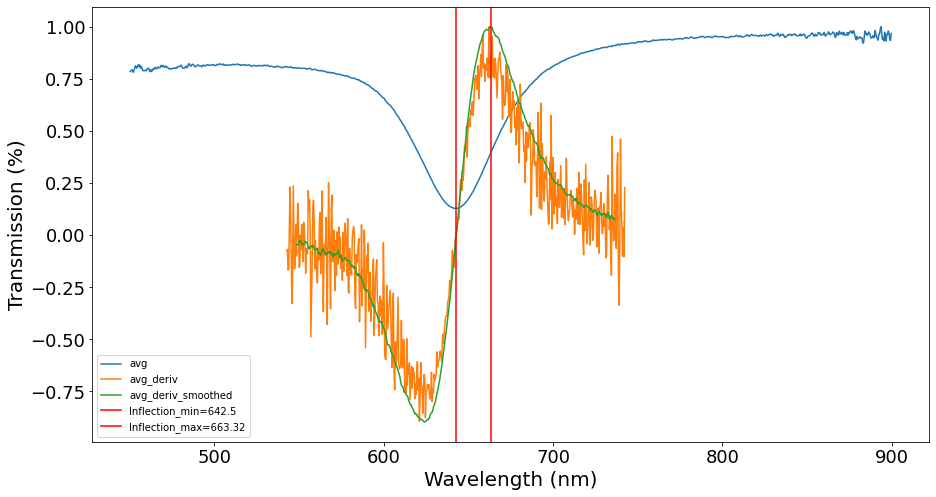

In [120]:

# Normalise each column to better scale for plotting
df = dp.normalise(df)

for col in df:
    if col == 'wavelength':
        pass
    else:
        plt.plot(df['wavelength'], df[col], label=col)

plt.xlabel("Wavelength (nm)", fontsize=20)
plt.ylabel("Transmission (%)", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
fig=plt.gcf()
fig.set_size_inches(15, 8)

plt.axvline(x=inflection_min, label=f"Inflection_min={inflection_min}", color='r')
plt.axvline(x=inflection_max, label=f"Inflection_max={inflection_max}", color='r')
plt.legend()

plt.show()